<h1 class="heading"> TUTORIAL 02</h1>
<h1>Complex maneuver, units conversion, trajectory visualization</h1>

<h6 class="author"> — <b style="color:rgb(0,51,102);">Carmine Varriale, Agostino De Marco</b>, <i>University of Naples Federico II</i></h6>

## 2.0 Initialization

In [1]:
% run ./python/nb_init.py                        
% matplotlib inline                              

import plotting_routines as plrt
import data_handling as dh

HTML(open('./style/style_unina_iwes.css', 'r').read())

## 2.1 JSBSim
### 2.1.1 Script launch

The script launched in this notebook performs a sequence of several operations, thanks to the definition of 3 main events:
1. trims the aircraft after 0.5 seconds;
2. performs an elevator doublet in the shape of $\sin(\pi \Delta t)$ after at least 5 seconds of trimmed flight, to appreciate the dynamic response of the aircraft;
3. activates the wing leveler autopilot after 30 seconds.
<br>
<br>

In the time histories of notable data, it is possible to appreciate the short period oscillations of $q$ and $\alpha$, and the long period phase opposition oscillations of $V$ and $h$. The complete script and its initialization file have been reported here for analysis.


In [2]:
# Reference to script file
script_path='../JSBSim/scripts/c172_elevator_doublet_C.xml'
dh.show_file(script_path)

   1| <?xml version="1.0"?>
   2| <?xml-stylesheet type="text/xsl" href="http://jsbsim.sourceforge.net/JSBSimScript.xsl"?>
   3| <runscript xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
   4|     xsi:noNamespaceSchemaLocation="http://jsbsim.sf.net/JSBSimScript.xsd"
   5|     name="C172 elevator doublet">
   6|   
   7|   <!--
   8|     This run is for testing the C172 at altitude with an elevator doublet applied
   9|   -->
  10| 
  11|   <use aircraft="c172x" initialize="elevator_doublet_init"/>
  12|   <run start="0.0" end="60" dt="0.0083333">
  13| 
  14|     <property> simulation/notify-time-trigger </property>
  15|     <property value="1"> simulation/run_id </property>
  16| 
  17|   <!--
  18|       For "do_simple_trim" (Classic trim):
  19|       0: Longitudinal
  20|       1: Full
  21|       2: Ground
  22|       3: Pullup
  23|       4: Custom
  24|       5: Turn
  25|       6: None
  26|   -->
  27|     
  28|     <event name="Trim">
  29|       <description>Trim at

In [3]:
# Directory house-keeping
dest_folder='../output/tutorial02/'

# Catalog to file
os.system('../JSBSim/JSBSim --root=../JSBSim/ --catalog=c172x > ../JSBSim/catalog_c172x.txt')

0

In [4]:
# Reference to initialization file
init_path = '../JSBSim/aircraft/c172x/elevator_doublet_init.xml'
dh.show_file(init_path)

# JSBSim script launch command
os.system('../JSBSim/JSBSim --root=../JSBSim/ --script='+script_path+' > ../JSBSim/log_tutorial02.txt')

   1| <?xml version="1.0"?>
   2| <initialize name="Elevator doublet init">
   3|   <!--
   4|     This file sets up the aircraft at 4000
   5| 	feet on a heading of 200 degrees.
   6|   -->
   7|   <vt unit="KTS">         96.0  </vt>
   8|   <latitude unit="DEG">   47.0  </latitude>
   9|   <longitude unit="DEG"> 122.0  </longitude>
  10|   <psi unit="DEG">       200.0  </psi>
  11|   <altitude unit="FT">  2000.0  </altitude>
  12|   <gamma unit="DEG">       0.0  </gamma>
  13|   <running> 0 </running>
  14| </initialize>


0

In [5]:
dh.move_files_to_folder('*.csv',dest_folder,'../JSBSim/')
dh.move_files_to_folder('*.txt',dest_folder,'../JSBSim/')

### 2.1.2 Time histories plotting

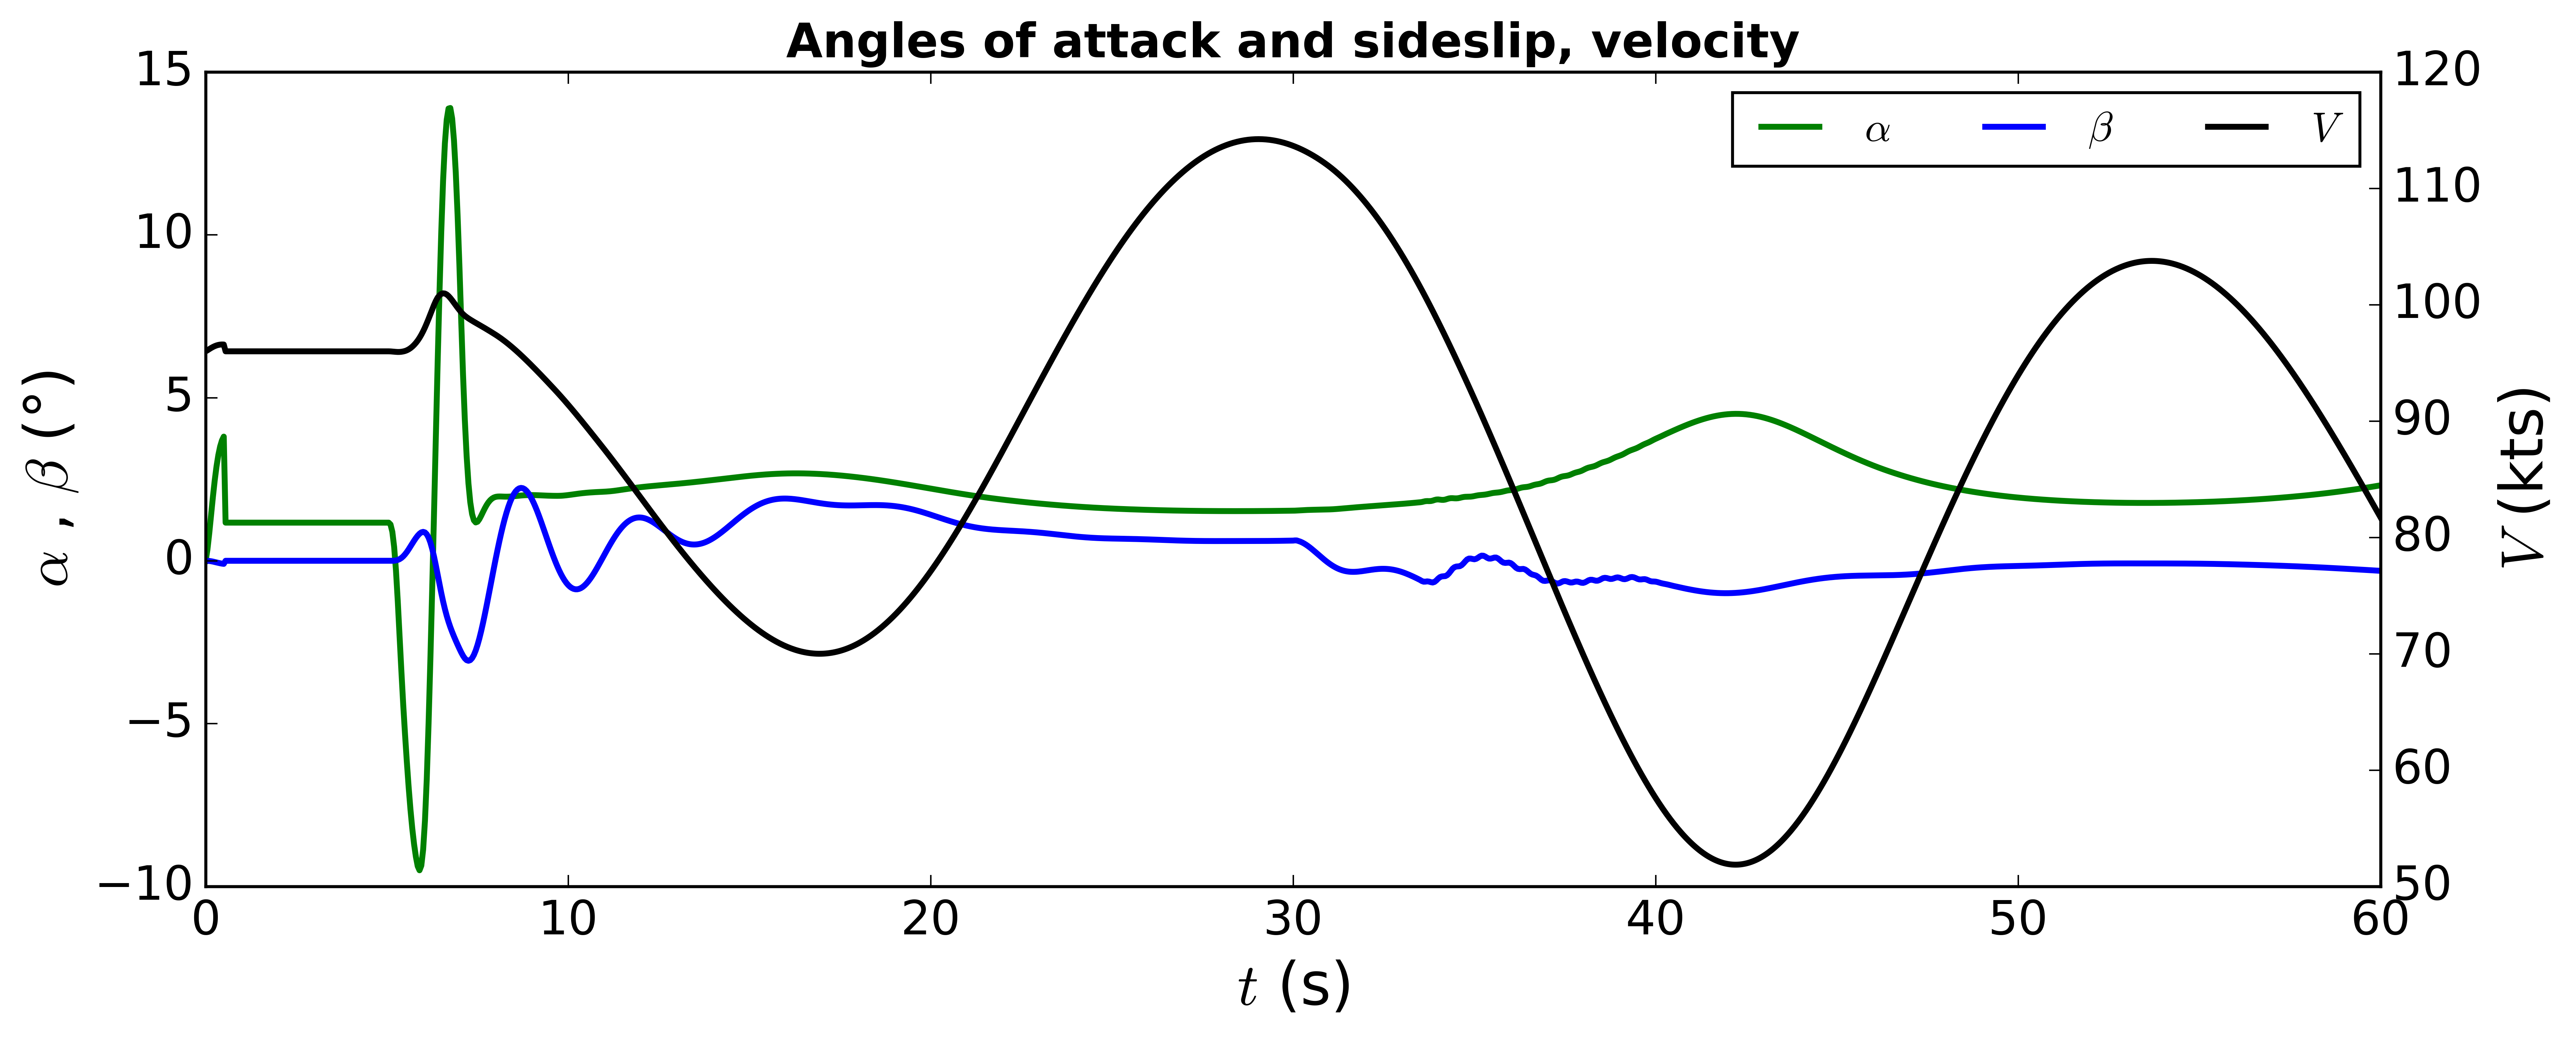

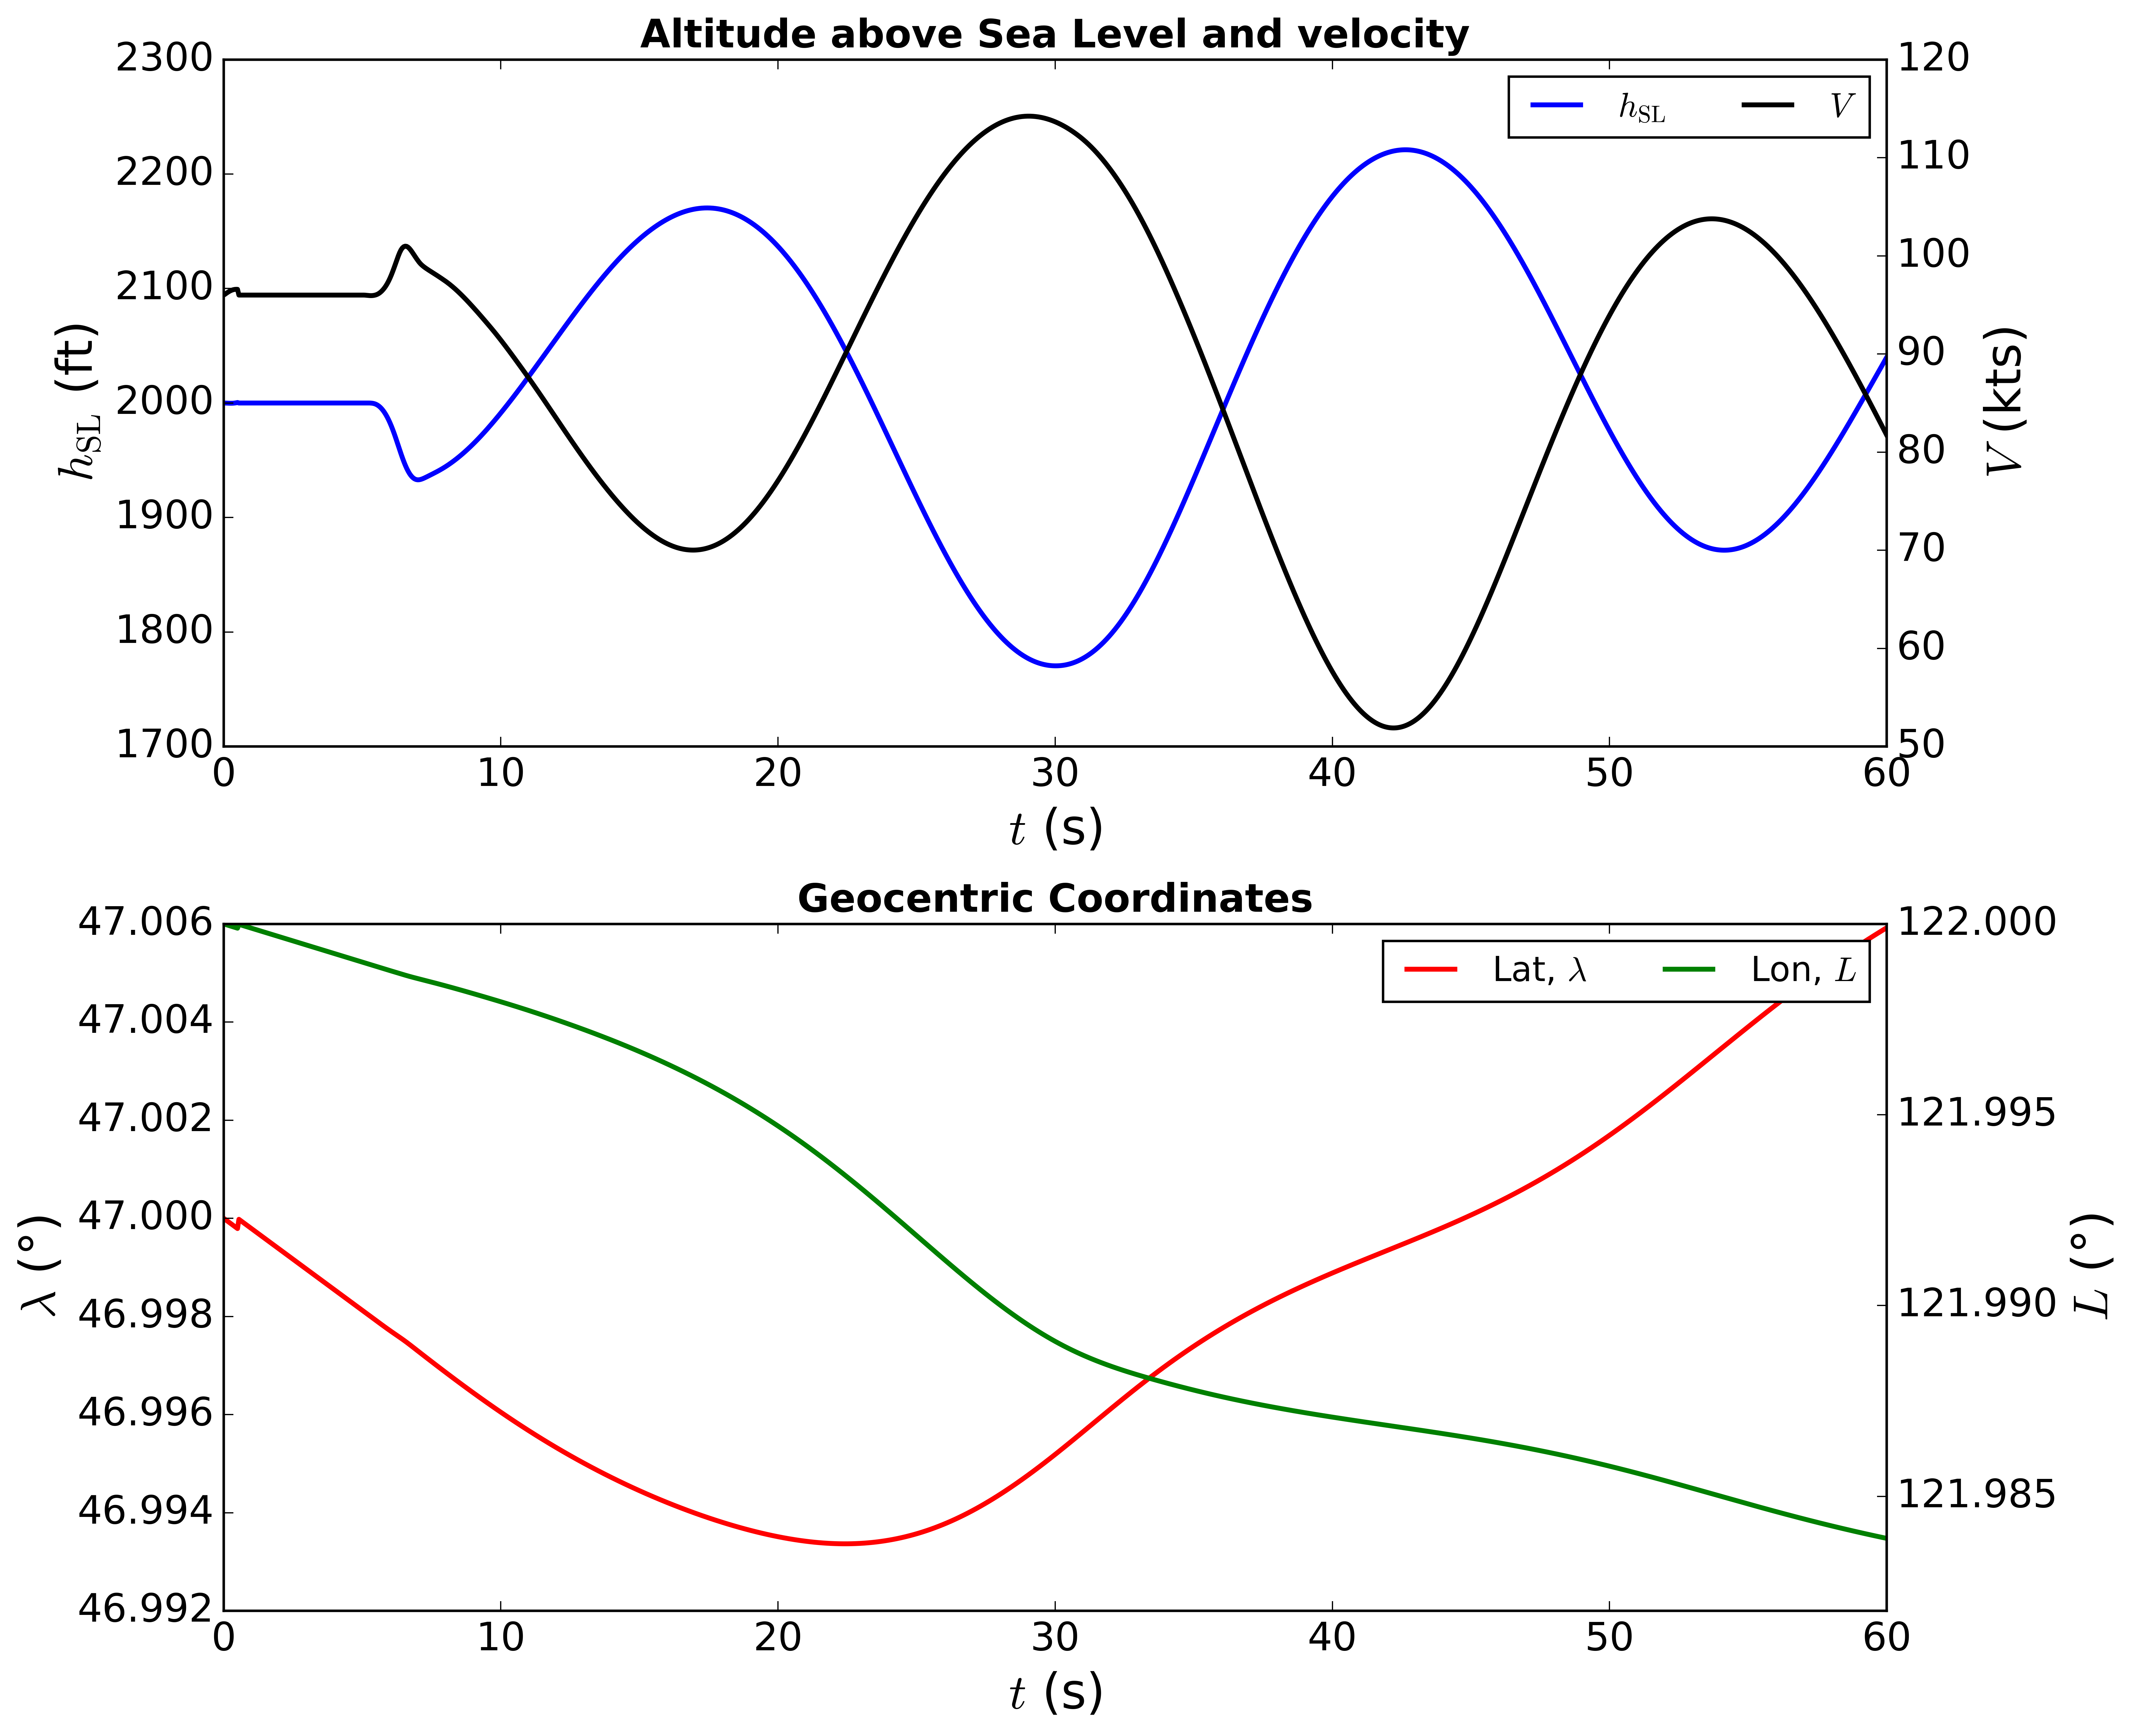

In [6]:
# Data extraction from JSBSim custom output files
data_fcs = np.genfromtxt(dest_folder+'c172_fcs.csv',       delimiter=',', skip_header=1)
data_vel = np.genfromtxt(dest_folder+'c172_velocities.csv',delimiter=',', skip_header=1)
data_att = np.genfromtxt(dest_folder+'c172_attitude.csv',  delimiter=',', skip_header=1)
data_aero = np.genfromtxt(dest_folder+'c172_aero.csv',     delimiter=',', skip_header=1)
data_pos = np.genfromtxt(dest_folder+'c172_position.csv',  delimiter=',', skip_header=1)
data_eng = np.genfromtxt(dest_folder+'c172_propulsion.csv',delimiter=',', skip_header=1)

# Time histories
plrt.plot_Cmd_AngVel_EulerAng(data_fcs, data_vel, data_att, dest_folder)
plrt.plot_Alfa_Beta_V(data_aero, data_vel, dest_folder)
plrt.plot_PosGeoc(data_pos, data_vel, dest_folder)
#plrt.plot_EngineStatus(data_eng, data_vel, dest_folder)

## 2.2 Trajectory visualization
### 2.2.1 Definition of a Python function for coordinate transformation

In order to correctly visualize the trajectory, we must first convert the geocentric position time history to a more intuitive reference frame. A classic choice would be the NED (North, East, Down) reference frame, but since the aircraft is of course flying above the ground, it would result in negative coordinates along the Z axis. Therefore, we decided to represent the trajectory in terms of North, East coordinates with respect to the starting point of the simulation, and altitude above the ground. <br><br>

To do so, a specific function was designed to convert latitude and longitude time histories to North-East time histories, while altitude is handled in a slightly different way (see function code below). It also contemplates the possibility of implementing two different Earth models: flat Earth and spherical Earth (with $R_\mathrm{E}=6371$ km), the former being used by default.<br><br>

If $\lambda$ denotes geocentric latitude and $L$ indicates longitude, the transformation from Earth Centerd Earth Fixed (ECEF) coordinates to North-East-Down (NED) coordinates is:

\begin{equation*}
     \left\{ R \right\}_\mathrm{ECEF}
     =
     \left\{
     \begin{array}{l}
       X_\mathrm{ECEF} \\
       Y_\mathrm{ECEF} \\
       Z_\mathrm{ECEF} \\
     \end{array}
     \right\}
     =
     \left\{
     \begin{array}{l}
       R_E \cos \lambda \cos L \\
       R_E \cos \lambda \sin L \\
       R_E \sin \lambda  \\
     \end{array}
     \right\}
     %
     \Longrightarrow
     %
     \left\{
     \begin{array}{l}
       X_\mathrm{N} \\
       Y_\mathrm{E} \\
       Z_\mathrm{D} \\       
     \end{array}
     \right\}
     =
     \left[
     \begin{array}{ccc}
       -\sin \lambda \cos L & -\sin \lambda \sin L & \cos L \\
       -\sin L              & \cos L               & 0 \\
       -\cos \lambda \cos L & -\cos \lambda \sin L & -\sin L \\
       \end{array}
     \right]
     %
     \left\{
     \begin{array}{l}
       R_E \cos \lambda \cos L \\
       R_E \cos \lambda \sin L \\
       R_E \sin \lambda  \\
     \end{array}
     \right\}
\end{equation*}

The function code is shown below for analysis. Consider taking a look at the <i>Notes</i> section of the function <i>Help</i> for some considerations about the Earth model and altitude management. A copy of the function definition has also been stored as a method of the module

<div class="path">./python/geography.py</div>

so that it can be referenced from other Notebooks in the future.

In [7]:
def geoc_to_NEA(lat,lon,h_sl,flat=1):

    """
    Converts the time histories of geocentric latitude, longitude and altitude above Sea Level
    to the time histories of North, East and altitude. The latter are expressed in a reference 
    frame whose origin is in the initial position (L,l) of the simulation, but at Mean Sea Level altitude.
    Earth is considered flat.

    Arguments
    -----------
    lat  = 1d array, rad
    lon  = 1d array, rad
    h_sl = 1d array, m
    flat = bool (default is 1)

    Output
    -----------
    3x1 array of arrays = [X_north, Y_east, h_sl], m

    Notes
    -----------
    Suppose h_sl is constant due to A/C altitude hold.
    With flat-Earth model implemented, like it is done here by default, altitude will actually remain constant
    also in the NED reference frame. If Earth were considered round, altitude would be expected to remain constant 
    with respect to Earth surface: therefore, actual altitude in the NED reference frame (which is fixed to the initial
    position of the aircraft) would clearly decrease because of Earth's curvature.

    """

    from numpy import array, cos, sin, arcsin, arctan2

    # Earth radius (assumed to be equal to MSL)
    R_E = 6371e3 # m

    # Time history of the A/C position in ECEF system
    R = (R_E+h_sl)*array([cos(lat)*cos(lon),  # X ECEF
                   cos(lat)*sin(lon),  # Y ECEF
                   sin(lat)])          # Z ECEF

    R0 = R[:,0]

    DR = array([R[i,:]-R0[i] for i in range(len(R0))])

    # Transformation matrix
    A = np.array([[-sin(lat[0])*cos(lon[0]), -sin(lat[0])*sin(lon[0]), +cos(lon[0])],
                  [-sin(lon[0]),              cos(lon[0]),             0          ],
                  [-cos(lat[0])*cos(lon[0]), -cos(lat[0])*sin(lon[0]), -sin(lat[0])]
                 ])

    r = A.dot(DR)
    
    # Check Earth model to set correct altitude time history
    if    flat == 1: r[-1] = h_sl          # flat Earth
    else           : r[-1] = -r[-1]+h_sl   # non-flat Earth
    
    return r

### 2.2.2 Units of measurement conversion

In order to use the coordinate transformation function correctly, we must ensure that its arguments are in the correct units of measurement: these are described in the function <i>Help</i>.

In [8]:
import geography as geo
help(geo.geoc_to_NEA)

Help on function geoc_to_NEA in module geography:

geoc_to_NEA(lat, lon, h_sl, lat0=None, lon0=None, flat=1)
    Converts the time histories of geocentric latitude, longitude and altitude above Sea Level
    to the time histories of North, East and altitude. The latter are expressed in a reference 
    frame whose origin is in the initial position (L,l) of the simulation, but at Mean Sea Level altitude.
    Earth is considered flat.
    
    Arguments
    -----------
    lat  = 1d array, rad
    lon  = 1d array, rad
    h_sl = 1d array, m
    flat = bool (default is 1)
    
    Output
    -----------
    3x1 array of arrays = [X_north, Y_east, h_sl], m
    
    Notes
    -----------
    Suppose h_sl is constant due to A/C altitude hold.
    With flat-Earth model implemented, like it is done here by default, altitude will actually remain constant
    also in the NED reference frame. If Earth were considered round, altitude would be expected to remain constant 
    with respect to Earth 

We can now either multiply our arrays by the correct conversion factor (for example, by using the Google conversion utility) or we can automate the process by using the __Pint__ module, which allows to handle physical quantities and unit conversions:

In [9]:
from pint import UnitRegistry;    # units of measurements, 'pip install -U pint'
unit = UnitRegistry()             # ex: 3*unit.m, 45*unit.cm, A.to(unit.km), A.magnitude, A.unit, ...

# Same code in nb_init.py (shown here for clarity)

In [10]:
# Variables assignment
t_pos     = data_pos[:,0]
hSL_ft    = data_pos[:,1]
LatGC_deg = data_pos[:,7]
LonGC_deg = data_pos[:,9]

# Variable conversion and magnitude extraction
lat = (LatGC_deg*unit.deg).to(unit.rad).magnitude
lon = (LonGC_deg*unit.deg).to(unit.rad).magnitude
h_sl = (hSL_ft*unit.ft).to(unit.m).magnitude

### 2.2.3 Trajectory plotting
We can now make a call to the function and obtain the time histories of North, East coordinates with respect to the starting point, and Altitude with respect to the ground in the chosen Earth model.<br>

In [11]:
r = geoc_to_NEA(lat,lon,h_sl,flat=1)

These are fed to the following plotting functions: one for 2D parallel visualization from above and from the side, and the other for 3D "bird's eye" view of the trajectory. Check their <i>Help</i> to see how they work.

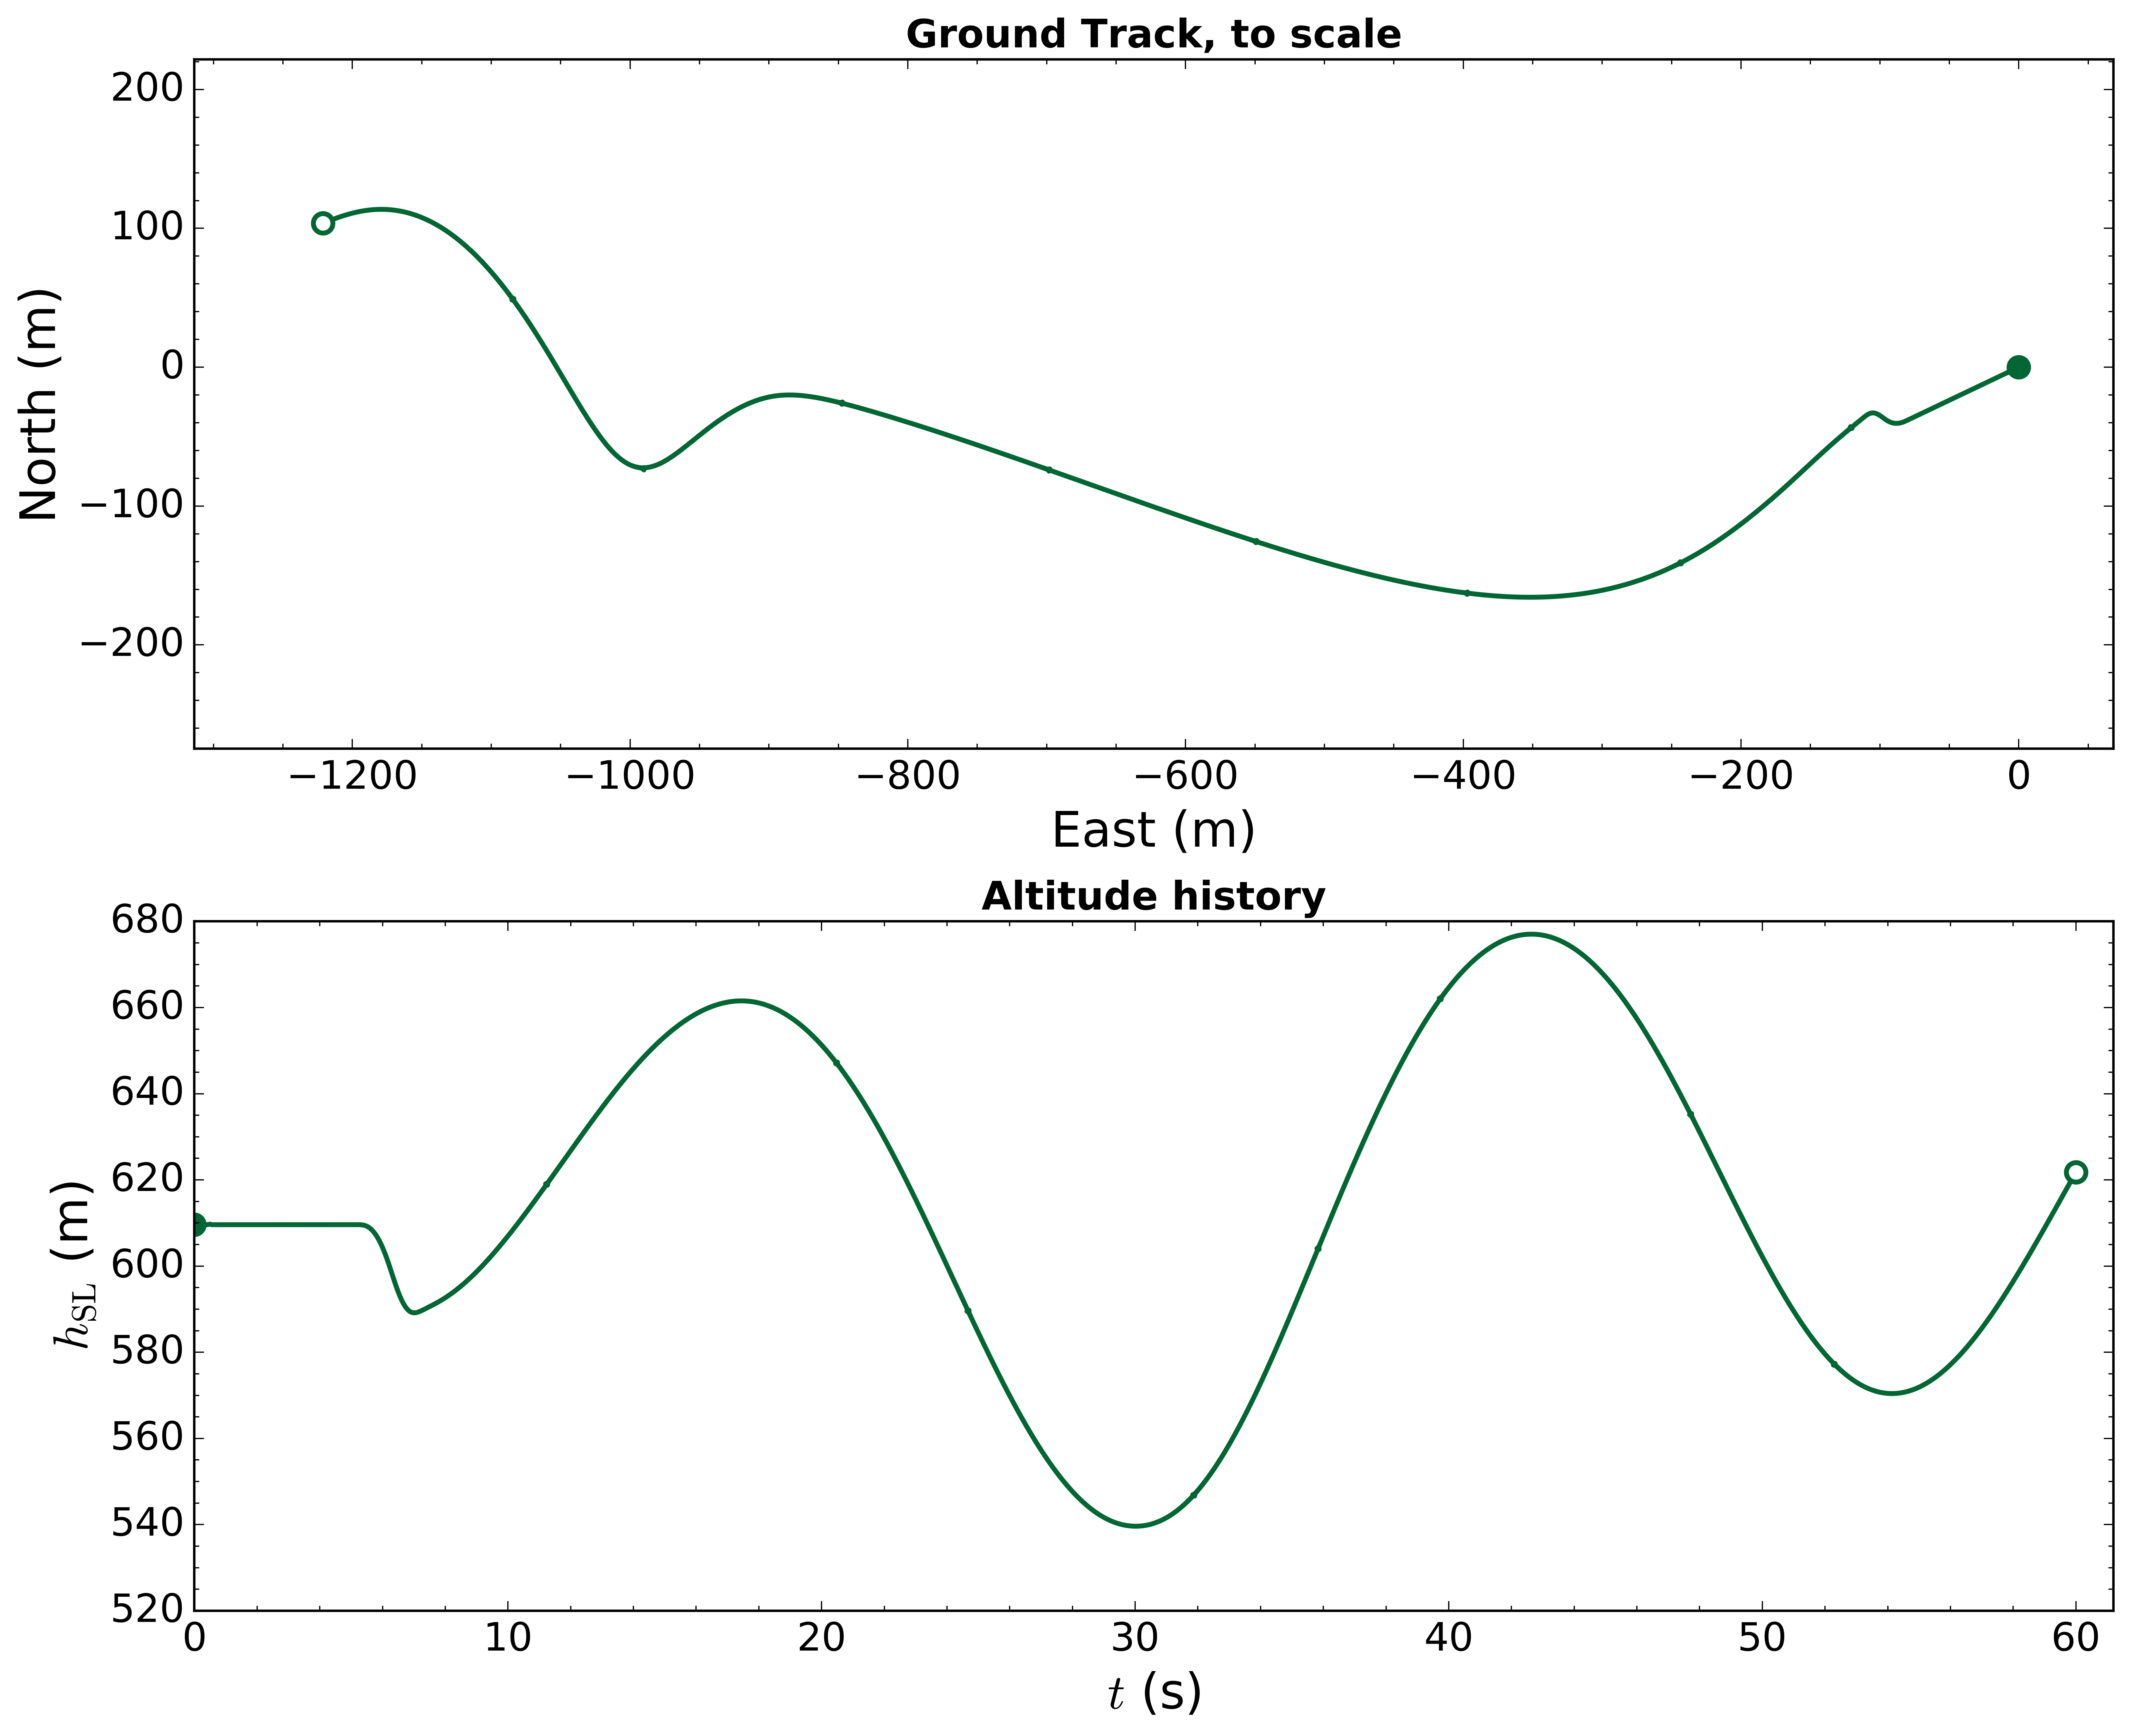

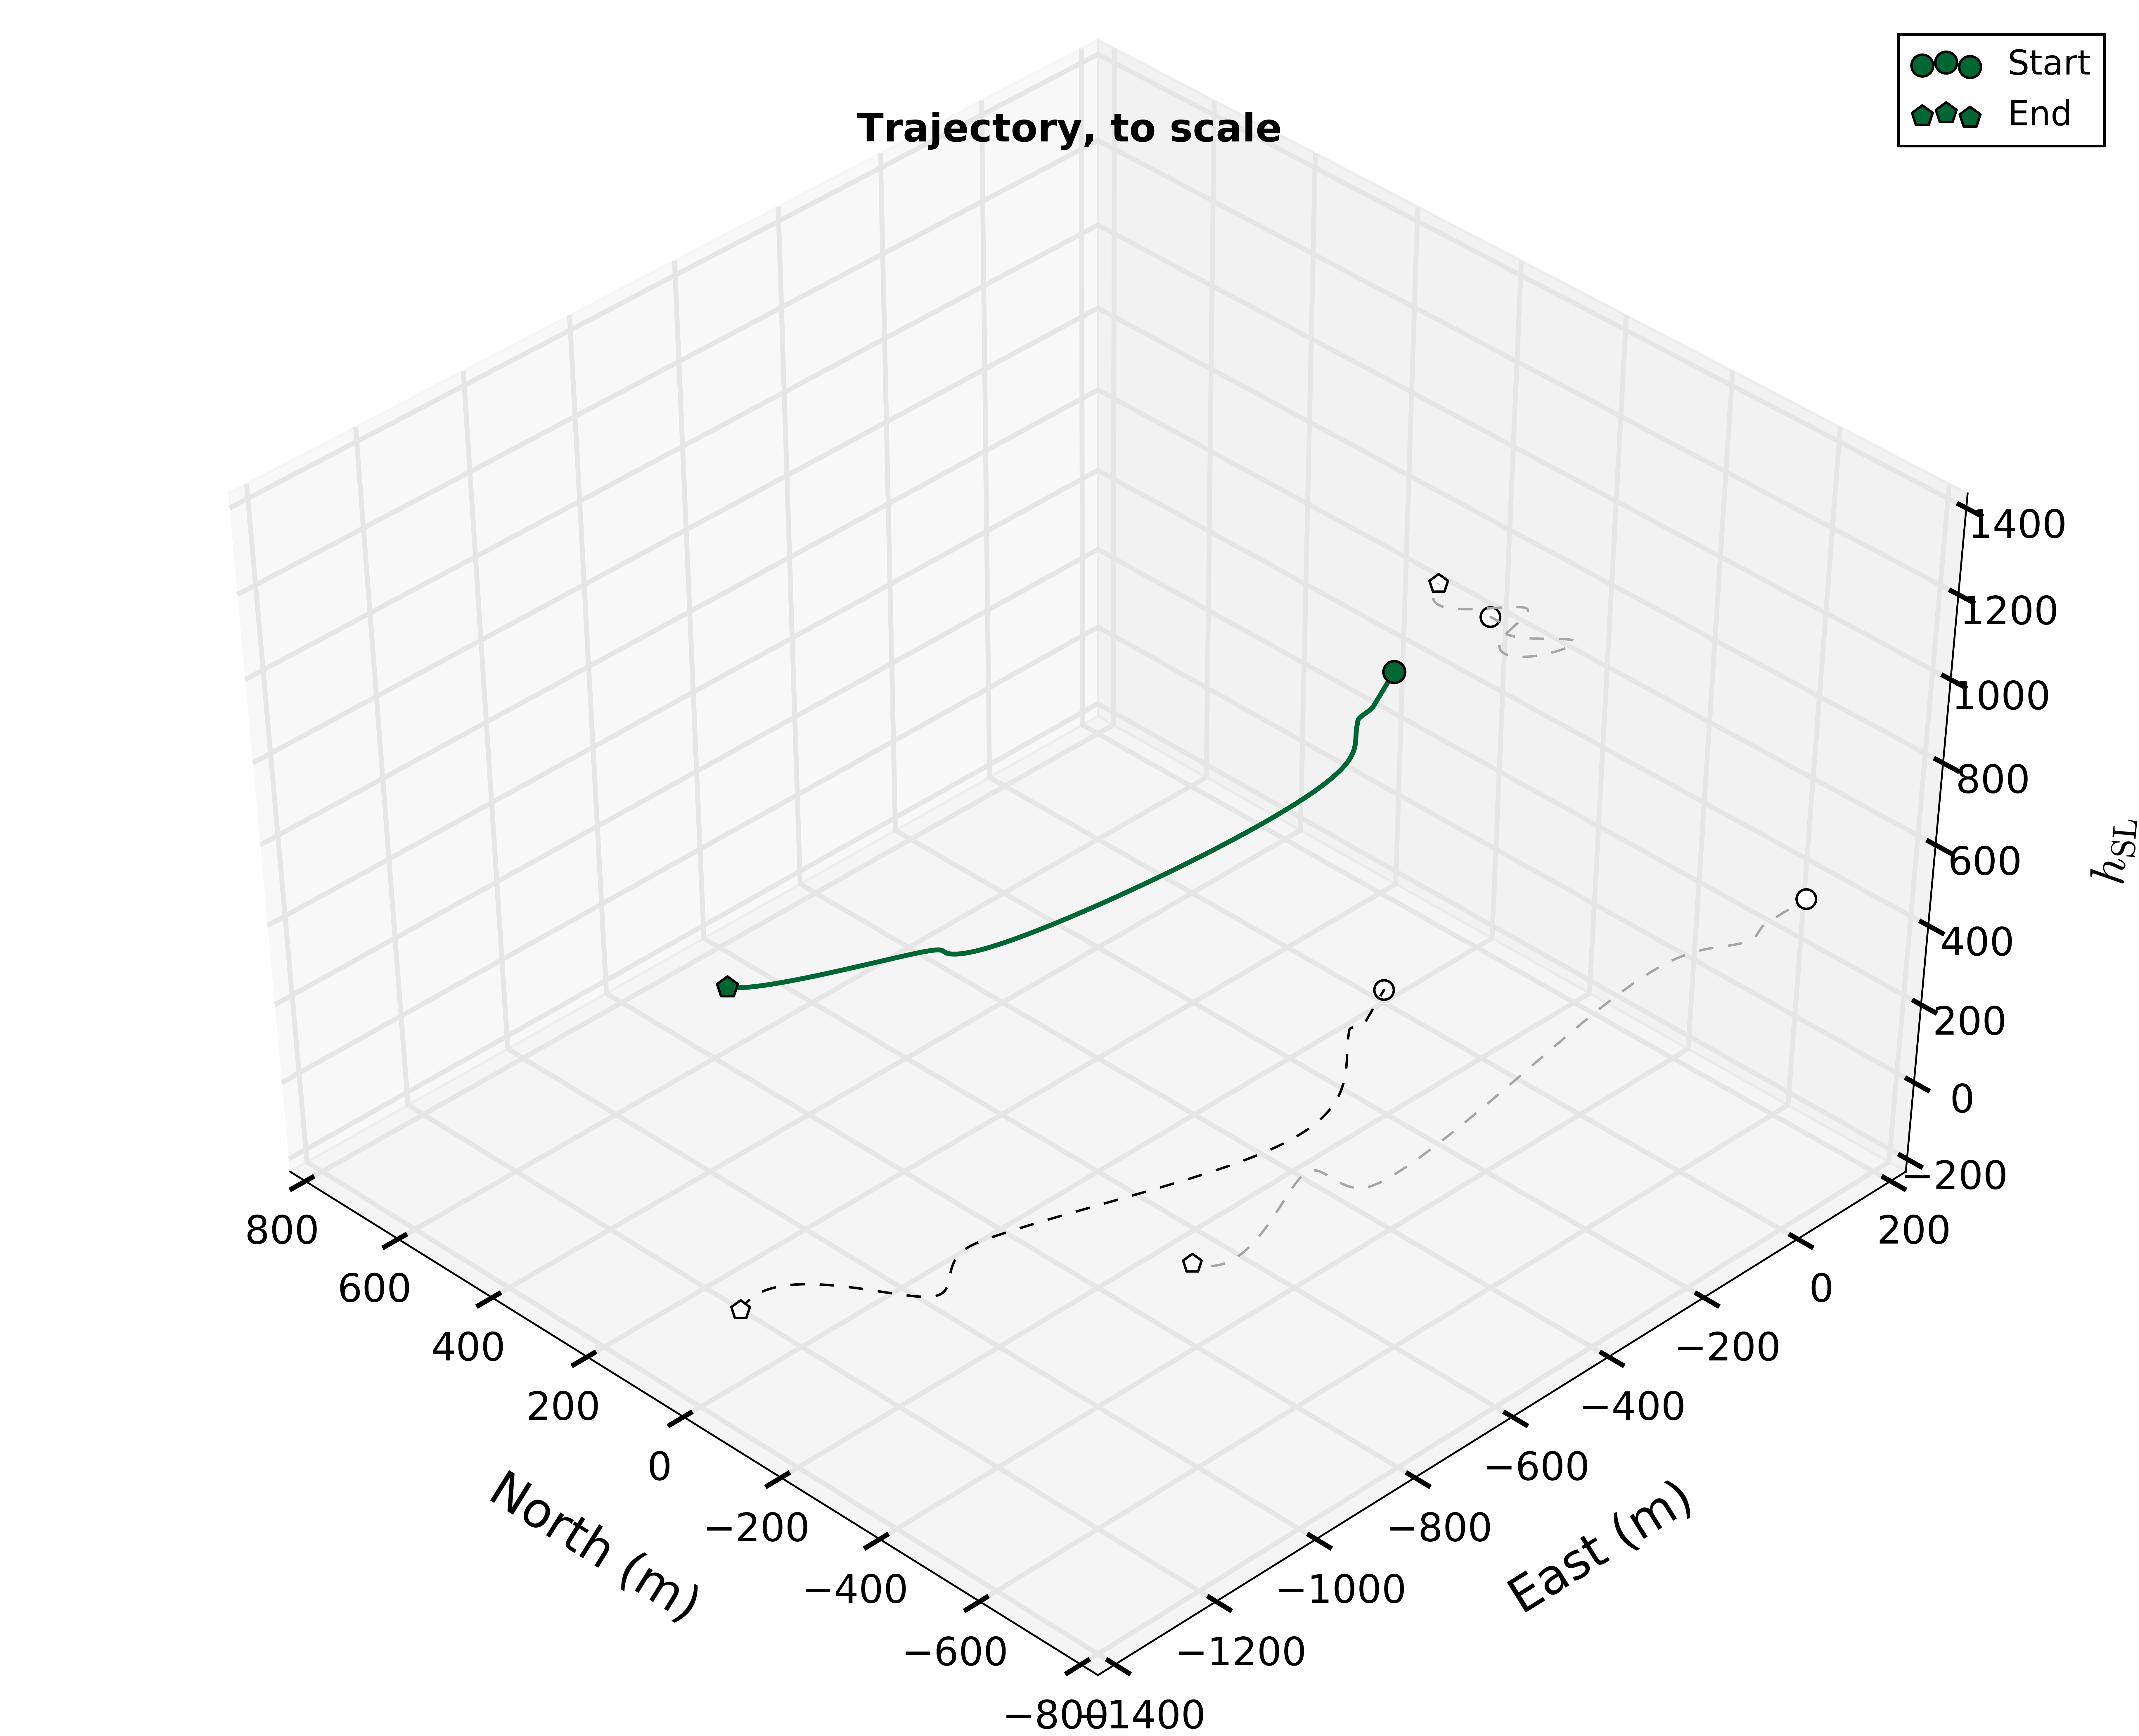

In [12]:
plrt.plot_traj2D_NEA(r,t_pos,n_arrows=8,arrow_size=2,dest_folder=dest_folder)
plrt.plot_traj3D_NEA(r,'S','E',(45,-45),to_scale='XYZ',mrk_size=80,dest_folder=dest_folder)